In [36]:
import data_helpers
import os
import pandas as pd

dataframes = {}
main_cats = ['ActionName', 'Capability']
for cat in main_cats:
    ls = os.listdir(os.getcwd() + "/" + cat)
    for file in ls:
        if cat not in file and '.csv' in file:
            df = pd.read_csv(os.getcwd() + "/" + cat + "/" + file, encoding='utf-8', engine='python')
            print(">>> {}:".format(file))
            print(df.label.value_counts(), df.columns.tolist(), '\n')
            dataframes[file.replace(".csv", "")] = df


>>> Other-Train.csv:
NoOther    698
Other      456
Name: label, dtype: int64 ['Unnamed: 0', 'label', 'text-rel', 'label_num', 'text-neigh'] 

>>> File-Test.csv:
no-File    19
File       15
Name: label, dtype: int64 ['Unnamed: 0', 'label', 'text-rel', 'label_num', 'text-neigh'] 

>>> Network-Train.csv:
NoNetwork    781
Network      373
Name: label, dtype: int64 ['Unnamed: 0', 'label', 'text-rel', 'label_num', 'text-neigh'] 

>>> Network-Test.csv:
no-Network    27
Network        7
Name: label, dtype: int64 ['Unnamed: 0', 'label', 'text-rel', 'label_num', 'text-neigh'] 

>>> Network-Dev.csv:
NoNetwork    30
Network      16
Name: label, dtype: int64 ['Unnamed: 0', 'label', 'text-neigh', 'label_num', 'text-rel'] 

>>> Other-Test.csv:
no-Other    22
Other       12
Name: label, dtype: int64 ['Unnamed: 0', 'label', 'text-rel', 'label_num', 'text-neigh'] 

>>> Other-Dev.csv:
NoOther    33
Other      13
Name: label, dtype: int64 ['Unnamed: 0', 'label', 'text-neigh', 'label_num', 'text-rel'] 

>>

In [37]:
dataframes['File-Train'].head()

,Unnamed: 0,label,text-rel,label_num,text-neigh
0,0,File,the driver creates device named \Device\vstor3...,1,"first executed, the driver creates device name..."
1,1,File,it cleans out those logs,1,"the server, and then cleans out those logs: 03..."
2,2,File,rootkit store configuration and log data,1,by the rootkit to store configuration and log ...
3,3,File,rootkit The files within that directory are used,1,files within that directory are used by the ro...
4,4,File,the pipe server saving data into a temporary file,1,"their behalf, such as saving data into a tempo..."


In [38]:
'''
Join Dev with Test, because why bother?
'''

for cat in dataframes.keys():
    if 'Test' in cat:
        new_df = dataframes[cat]
        for ccat in dataframes.keys():
            if 'Dev' in ccat and ccat.replace("Dev", "Test") == cat:
#                 new_df = pd.concat([new_df, dataframes[ccat]], sort=False)
                new_df = new_df.append(dataframes[ccat], ignore_index=True)
                dataframes[cat] = new_df
                
dataframes = {cat : dataframes[cat] for cat in dataframes if 'Dev' not in cat}

/home/jells123/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [39]:
from tokenizer import TheTokenizer
my_tokenizer = TheTokenizer(stem=False, lem=False, stopword=False)

In [40]:
'''
Process data from sentences to list of words:
- remove punctuation
- convert to lowercase
- split by whitespace to get list
- stem or lemmatize
- remove stopwords
- remove one-char words?
- remove words longer than 30 (probably some hashes)
'''

import re
from nltk import word_tokenize, pos_tag     
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

for cat in dataframes.keys():
    df = dataframes[cat]
    print(">>> {}".format(cat))
    cols = df.columns.tolist()
    for c in cols:
        if 'text' in c and 'token' not in c and 'processed' not in c:
            
            data = df[c]
#             print(data[0:1]) 
#(BEFORE)
            
            data = data.apply(lambda x : re.sub(r'[,\[\]\(\)"’]', '', x))
            data = data.apply(lambda x : x.lower())
            data = data.apply(lambda x : x.split())
            
            data = data.apply(lambda tokens : [my_tokenizer.stem_token(t) for t in tokens])
#             data = data.apply(lambda tokens : [my_tokenizer.lemmatize_token(t, pos) for t, pos in pos_tag(tokens)])
            
            data = data.apply(lambda tokens : [t for t in tokens if t not in stopwords])
        
            data = data.apply(lambda tokens : ['hash-code' if len(t) >= 31 else t for t in tokens])
            data = data.apply(lambda tokens : [t for t in tokens if len(t) > 1 and len(t) <= 20])
            
            df['{}-processed'.format(c)] = data.apply(lambda x : ' '.join(x))

#             print(data[0:1])
#(AFTER)


>>> Other-Train
>>> File-Test
>>> Network-Train
>>> Network-Test
>>> Other-Test
>>> File-Train
>>> command_and_control-Test
>>> infection_propagation-Train
>>> infection_propagation-Test
>>> other-Train
>>> command_and_control-Train
>>> other-Test


Komentarz NLP Stanford to Stemming vs Lemmatization:
    https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [41]:
'''
Attempt to replace some of very-unique words, such as file name, URL... 
(unfortunately not all are replaced, example: some long hashes and codes),
as well as remove YEAR (four digits)
'''

from data_helpers import clean_dataframe

print("Data cleaning examples:")
for cat in dataframes.keys():
    df = dataframes[cat]
    print('\n', df.at[0, 'text-rel-processed'])
    df = clean_dataframe(df)
    dataframes[cat] = df
    print(df.at[0, 'text-rel-processed'])

Data cleaning examples:

 driver creat devic name \device\vstor32 symbol link \dosdevices\vstor32
driver creat devic name system-path  symbol link system-path 

 bda9.tmp execut
 tmp-file execut

 driver creat devic name \device\vstor32 symbol link \dosdevices\vstor32
driver creat devic name system-path  symbol link system-path 

 bda9.tmp execut
 tmp-file execut

 bda9.tmp execut
 tmp-file execut

 driver creat devic name \device\vstor32 symbol link \dosdevices\vstor32
driver creat devic name system-path  symbol link system-path 

 use command-and-control c&c server attack
use command-and-control c&c server attack

 command control destin malwar
command control destin malwar

 use command-and-control c&c server attack
use command-and-control c&c server attack

 command control destin malwar
command control destin malwar

 command control destin malwar
command control destin malwar

 use command-and-control c&c server attack
use command-and-control c&c server attack


In [42]:
'''
Create -tokens columns (list of words)
'''

for cat in dataframes.keys():
    df = dataframes[cat]
    cols = df.columns.tolist()
    for c in cols:
        if 'processed' in c:
            data = df[c]
            data = data.apply(lambda x : x.split())
            label = c.replace('processed', 'tokens')
            df[label] = data

In [26]:
def dummy(doc):
    return doc

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy
)

'''
Count unique words in all datasets after we processed them into tokens.
Compare -relations and -neighbours features.
What is the size of BOW?
'''

for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("Liczba dokumentów: {x}".format(x=X_counts.shape[0]))
    print("Rozmiar wektora bag-of-words {x}".format(x=X_counts.shape[1]))
    
    print("\nModel 'sąsiedzi':")
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("Liczba dokumentów: {x}".format(x=X_counts.shape[0]))
    print("Rozmiar wektora bag-of-words {x}".format(x=X_counts.shape[1]))
    
    if 'Test' in cat:
        df_joined = df
        for ccat in dataframes.keys():
            if ccat.replace('Train', 'Test') == cat:
                df_joined = df_joined.append(dataframes[ccat], ignore_index=True)
                
                # Łączymy dataframe'y treningowe i testowe aby pokazać, że reprezentacja BOW
                # nie przyniesie 100% rezultatów - występują słowa które są w Train i nie ma ich w Test lub na odwrót
                print("\n>>> Połączenie {} + {}:".format(cat, ccat))
                X_counts = vectorizer.fit_transform(df_joined['text-rel-tokens'])
                print("Relacyjnie: {x}".format(x=X_counts.shape[1]))
                
                X_counts = vectorizer.fit_transform(df_joined['text-neigh-tokens'])
                print("Sąsiedzi: {x}".format(x=X_counts.shape[1]))
                
                break


>>> Other-Train

Model z relacjami:
Liczba dokumentów: 1154
Rozmiar wektora bag-of-words 1327

Model 'sąsiedzi':
Liczba dokumentów: 1154
Rozmiar wektora bag-of-words 1443

>>> File-Test

Model z relacjami:
Liczba dokumentów: 80
Rozmiar wektora bag-of-words 236

Model 'sąsiedzi':
Liczba dokumentów: 80
Rozmiar wektora bag-of-words 246

>>> Połączenie File-Test + File-Test:
Relacyjnie: 236
Sąsiedzi: 246

>>> Network-Train

Model z relacjami:
Liczba dokumentów: 1154
Rozmiar wektora bag-of-words 1327

Model 'sąsiedzi':
Liczba dokumentów: 1154
Rozmiar wektora bag-of-words 1443

>>> Network-Test

Model z relacjami:
Liczba dokumentów: 80
Rozmiar wektora bag-of-words 236

Model 'sąsiedzi':
Liczba dokumentów: 80
Rozmiar wektora bag-of-words 246

>>> Połączenie Network-Test + Network-Train:
Relacyjnie: 1374
Sąsiedzi: 1509

>>> Other-Test

Model z relacjami:
Liczba dokumentów: 80
Rozmiar wektora bag-of-words 236

Model 'sąsiedzi':
Liczba dokumentów: 80
Rozmiar wektora bag-of-words 246

>>> Połącz

W arkuszu kalkulacyjnym możemy zobaczyć jak redukował się rozmiar BOW po przetworzeniu tekstu.
https://docs.google.com/spreadsheets/d/1KUDvUCe77z-SJ9EKlfW-axWSYfTmHRG9v59b3BqvKmY/edit?usp=sharing

In [27]:
from data_helpers import get_top_occuring_words

'''
Show top occuring words found by our vectorizer.
We get words such as 'malwar' because we applied stemming to our datasets.
'''

how_many_words = 20
for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("\tbag-of-words: {x}".format(x=X_counts.shape[1]))
    
    vocab = list(map(lambda x : [len(x), x], sorted(vectorizer.vocabulary_.keys(), key=lambda x : -1*len(x))))
    print("\t- longest words:")
    print(vocab[:how_many_words])
    print("\t- shortest words:")
    print(vocab[-how_many_words:])
    
    print("\t TOP:")
    result = get_top_occuring_words(X_counts, 10, vectorizer, df)
    for entry in result:
        print(entry[0])
        print(entry[1])
    
    print("\nModel 'sąsiedzi':")
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("\tbag-of-words: {x}".format(x=X_counts.shape[1]))
    
    vocab = list(map(lambda x : [len(x), x], sorted(vectorizer.vocabulary_.keys(), key=lambda x : -1*len(x))))
    print("\t- longest words:")
    print(vocab[:how_many_words])
    print("\t- shortest words:")
    print(vocab[-how_many_words:])
    
    print("\t TOP:")
    result = get_top_occuring_words(X_counts, 10, vectorizer, df)
    for entry in result:
        print(entry[0])
        print(entry[1])



>>> Other-Train

Model z relacjami:
	bag-of-words: 1327
	- longest words:
[[20, 'shared$=%systemroot%'], [19, 'command-and-control'], [19, 'name>&&mux=<encrypt'], [18, 'zwterminateprocess'], [18, '‘collectw3perfdata'], [18, 'savadminservice.ex'], [17, 'apptransferwiz.dl'], [17, 'nato_smtp@mail.ru'], [17, 'sharedtaskschedul'], [16, 'loadembeddedimag'], [16, 'nato_pop@mail.ru'], [16, 'internetopenurla'], [16, '3443-4344-c4ffff'], [16, 'attacker-control'], [16, 'hyf54&%9&jkmcxui'], [16, 'winlogonuserinit'], [15, 'internetreadfil'], [15, 'ccprojectmgr.ex'], [15, 'deviceiocontrol'], [15, 'dbt_devicearriv']]
	- shortest words:
[[2, 'c0'], [2, 'b8'], [2, '3c'], [2, 'e5'], [2, '51'], [2, '64'], [2, '80'], [2, 'io'], [2, 'us'], [2, '10'], [2, 'xp'], [2, 'rc'], [2, 'os'], [2, 'hi'], [2, 'vb'], [2, 'vm'], [2, 'dn'], [2, '14'], [2, 'av'], [2, 'er']]
	 TOP:
NoOther
[('file', 198.0), ('execut', 99.0), ('malwar', 91.0), ('download', 86.0), ('thi', 71.0), ('command', 67.0), ('server', 66.0), ('connec

no-Other
[('page', 4.0), ('login', 4.0), ('victim', 4.0), ('log', 3.0), ('event', 3.0), ('eve-file', 3.0), ('dropper', 3.0), ('execut', 2.0), ('dump', 2.0), ('file', 2.0)]
Other
[('process', 8.0), ('registri', 5.0), ('malwar', 5.0), ('creat', 4.0), ('run', 3.0), ('use', 3.0), ('execut', 3.0), ('server', 3.0), ('name', 2.0), ('valu', 2.0)]
NoOther
[('file', 17.0), ('server', 8.0), ('download', 8.0), ('carbanak', 5.0), ('copi', 5.0), ('drop', 4.0), ('data', 4.0), ('c2', 4.0), ('system-path', 3.0), ('malwar', 3.0)]

Model 'sąsiedzi':
	bag-of-words: 246
	- longest words:
[[14, 'administrator.'], [13, 'doublefantasi'], [13, 'capabilities.'], [13, 'some-variable'], [12, 'self-delete.'], [11, 'system-path'], [11, 'executable.'], [11, 'keystrokes;'], [10, 'reconnaiss'], [10, 'screenshot'], [10, 'first-stag'], [10, 'termservic'], [9, 'explorer.'], [9, 'similarli'], [9, 'microsoft'], [9, 'software.'], [9, 'side-load'], [9, 'defenses.'], [9, 'payloads.'], [9, 'temporari']]
	- shortest words:
[[3,

no-infection/propagation
[('use', 254.0), ('thi', 191.0), ('file', 191.0), ('attack', 157.0), ('command', 147.0), ('malwar', 144.0), ('data', 143.0), ('server', 127.0), ('execut', 118.0), ('c&c', 111.0)]
infection/propagation
[('attack', 98.0), ('use', 79.0), ('target', 61.0), ('infect', 56.0), ('exploit', 48.0), ('thi', 47.0), ('malwar', 36.0), ('file', 33.0), ('email', 30.0), ('wa', 28.0)]

>>> infection_propagation-Test

Model z relacjami:
	bag-of-words: 505
	- longest words:
[[19, 'command-and-control'], [16, 'man-in-the-middl'], [16, 'attacker-control'], [15, 'privilege-escal'], [13, 'liveupdate.ex'], [13, 'self-destruct'], [13, 'cve-2012-0158'], [13, 'cve-2014-1761'], [12, 'intermediari'], [12, 'equationdrug'], [12, 'mediasoft.ex'], [11, 'system-path'], [11, 'malware-rel'], [11, 'shellexecut'], [11, 'vietnamese-'], [11, 'windows-bas'], [11, 'architectur'], [10, 'self-delet'], [10, 'reconnaiss'], [10, 'screenshot']]
	- shortest words:
[[3, 'tmg'], [3, 'etc'], [3, 'atm'], [3, 'add'

no-other
[('server', 25.0), ('c&c', 15.0), ('c2', 9.0), ('malwar', 7.0), ('report', 7.0), ('attack', 6.0), ('use', 6.0), ('configur', 5.0), ('infect', 5.0), ('command', 4.0)]
other
[('file', 19.0), ('system', 17.0), ('data', 16.0), ('malwar', 15.0), ('thi', 15.0), ('infect', 12.0), ('server', 12.0), ('attack', 11.0), ('tool', 11.0), ('access', 10.0)]

Model 'sąsiedzi':
	bag-of-words: 500
	- longest words:
[[19, 'command-and-control'], [16, 'man-in-the-middl'], [15, 'infrastructure.'], [15, 'communications.'], [15, 'privilege-escal'], [14, 'automatically.'], [13, 'self-destruct'], [13, 'doublefantasi'], [13, 'certificates.'], [13, 'cve-2014-1761'], [12, 'self-delete.'], [12, 'intermediari'], [12, 'equationdrug'], [12, 'mediasoft.ex'], [12, 'compromised.'], [12, 'particularli'], [11, 'system-path'], [11, 'infections.'], [11, 'shellexecut'], [11, 'appendixes.']]
	- shortest words:
[[3, 'ssh'], [3, 'rat'], [3, 'via'], [3, 'get'], [3, 'mbr'], [3, 'got'], [3, 'at-'], [3, 'add'], [3, 'act'], 

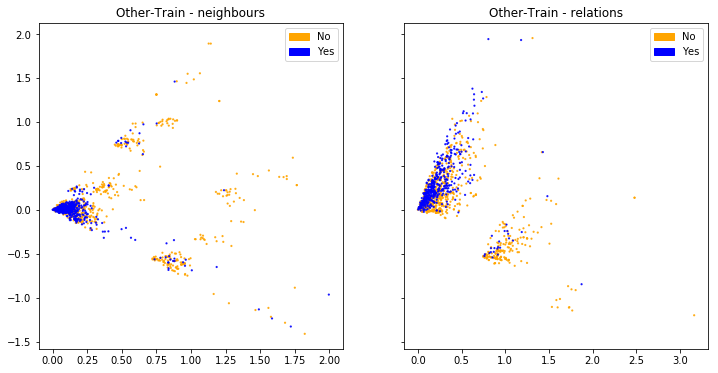

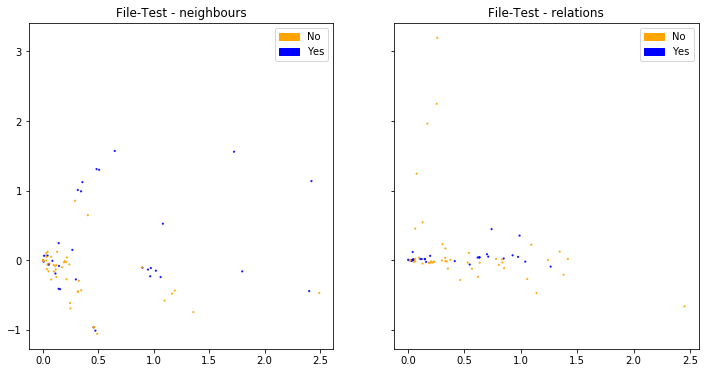

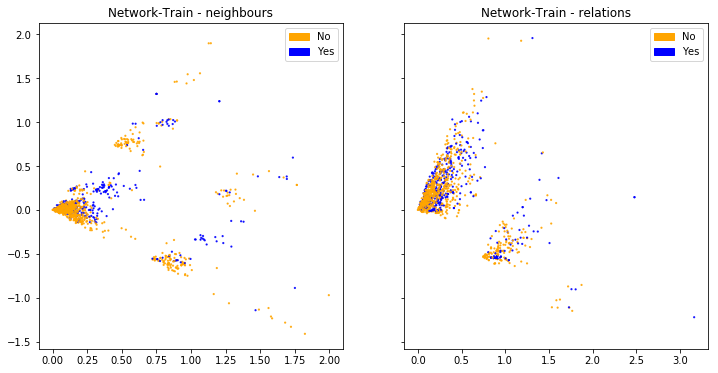

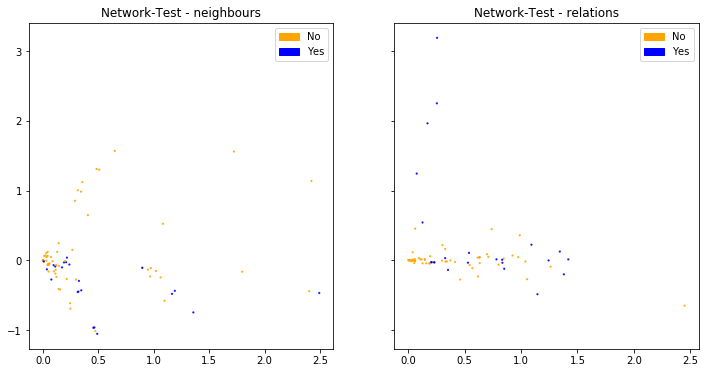

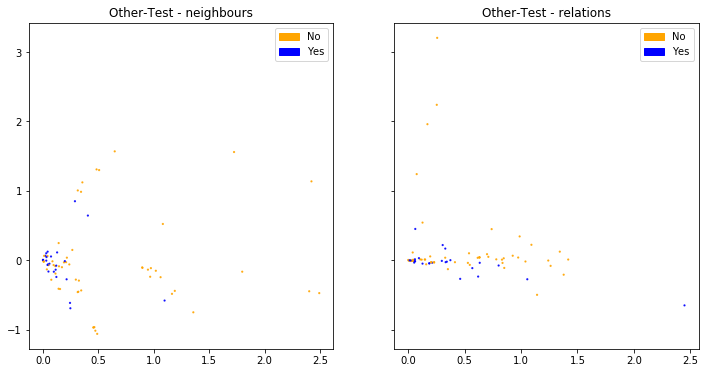

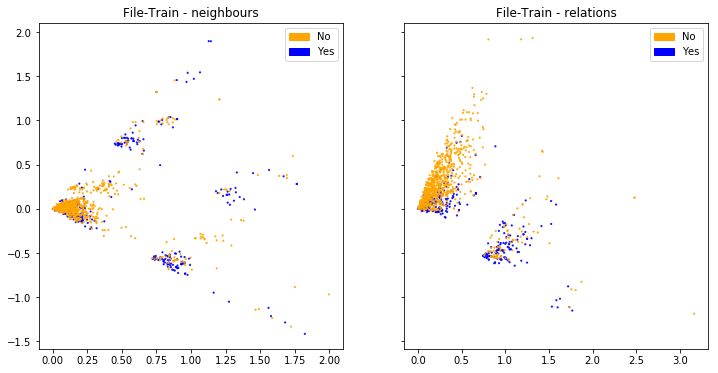

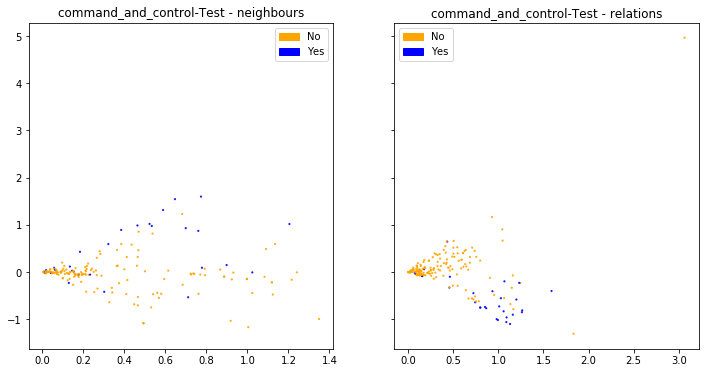

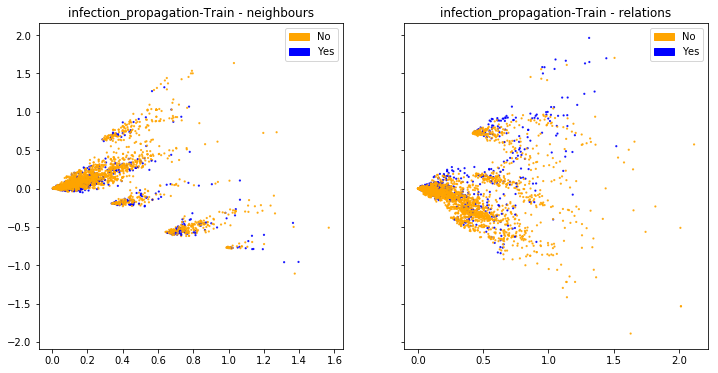

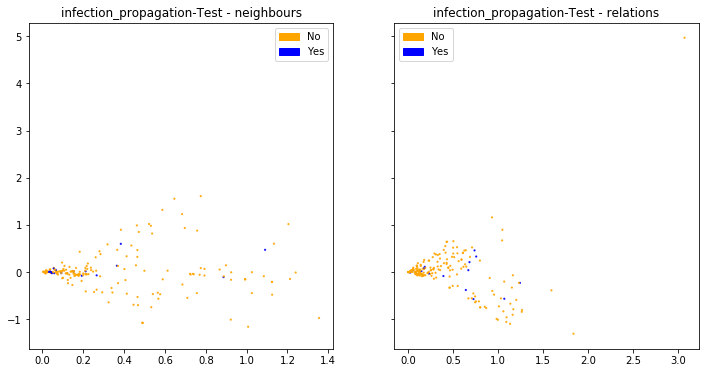

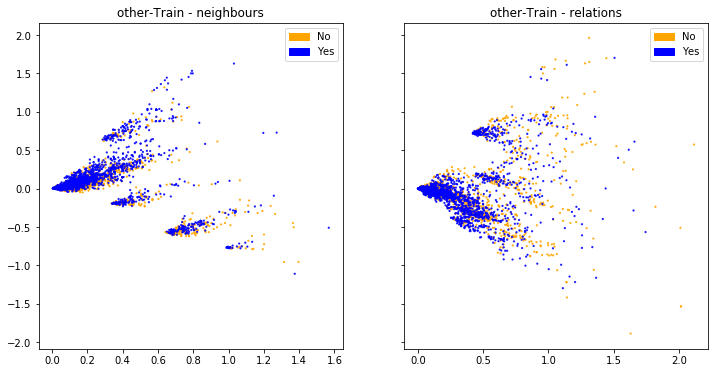

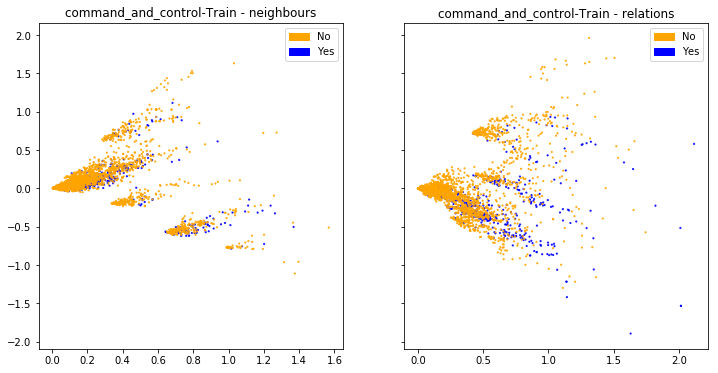

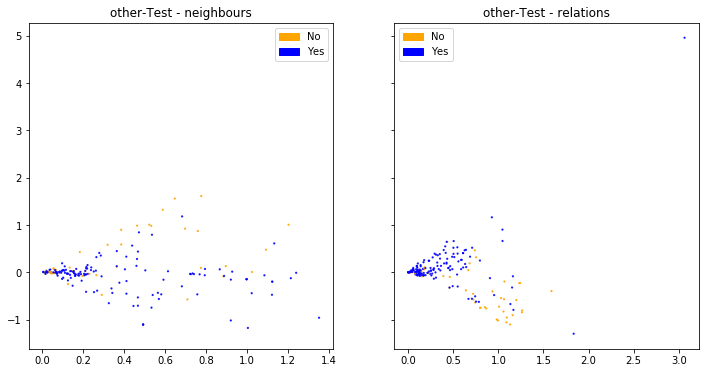

In [29]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

'''
Display PCA analysis results for the vectorizer above.
'''

def plot_LSA(test_data, test_labels, ax, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        
        if plot:
            ax.scatter(lsa_scores[:,0], lsa_scores[:,1], s=1.5, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='No')
            green_patch = mpatches.Patch(color='blue', label='Yes')
            ax.legend(handles=[red_patch, green_patch], prop={'size': 10})

for cat in dataframes.keys():

    df = dataframes[cat]
    labels = df['label_num'].tolist()
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
    
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens'])
    plot_LSA(X_counts, labels, ax1)
    ax1.set_title("{} - neighbours".format(cat))
    
    X_counts = vectorizer.fit_transform(df['text-rel-tokens'])
    plot_LSA(X_counts, labels, ax2)
    ax2.set_title("{} - relations".format(cat))
    
    


In [30]:
'''
Take another try with TF IDF vectorizer
for min_df = 0.1 we get only words common for both classes, such as 'file', 'data', 'malwar' ...
- min_df = 0.05 is quite better, but doesn't show differences neither

'''

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    max_df=0.05
)

In [31]:
for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, 10, vectorizer, df)
    for entry in result:
        print(entry[0])
        print(entry[1])
    
    print("\nModel 'sąsiedzi':")
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, 10, vectorizer, df)
    for entry in result:
        print(entry[0])
        print(entry[1])


>>> Other-Train

Model z relacjami:
bag-of-words: 1313
NoOther
[('upload', 20.814932639369335), ('attack', 18.212039414347345), ('c&c', 14.717019431150202), ('dropper', 14.379594096445043), ('send', 14.301057592430176), ('com-file', 13.929241698029863), ('delet', 13.628948364140154), ('copi', 13.06421153946895), ('write', 12.75084867445688), ('creat', 12.051504881411287)]
Other
[('hook', 15.499770018081316), ('servic', 15.264658629721888), ('request', 13.838331680205723), ('registri', 12.985759177432064), ('pipe', 11.990890875814962), ('post', 11.75549943365872), ('call', 11.347531461828078), ('api', 10.471466857127378), ('name', 10.19079754982894), ('key', 10.145719211856091)]

Model 'sąsiedzi':
bag-of-words: 1429
NoOther
[('command', 16.746925697212617), ('send', 13.94044575993644), ('copi', 13.026739648144588), ('write', 12.962088363055736), ('delet', 12.44589842381992), ('disk', 12.40964784473976), ('drop', 11.75969160412953), ('c&c', 10.375922811493854), ('sent', 10.1685668881621

File
[('delet', 13.628948364140154), ('write', 12.75084867445688), ('creat', 12.051504881411287), ('disk', 11.949885307812826), ('copi', 11.735682189635384), ('dropper', 11.600444318120797), ('written', 7.820670799821106), ('log', 7.48824083094832), ('attack', 6.553394206093898), ('hash-code', 6.120843078367121)]
NoFile
[('upload', 22.597857839953473), ('send', 18.551332358274166), ('request', 18.448408624044756), ('c&c', 16.847766447810116), ('hook', 15.80671230674047), ('servic', 15.50456363303949), ('com-file', 14.465215832640485), ('sent', 13.594115615129493), ('post', 13.299095348515914), ('call', 13.163009162271054)]

Model 'sąsiedzi':
bag-of-words: 1429
File
[('write', 12.962088363055736), ('disk', 12.40964784473976), ('copi', 11.245026611069106), ('delet', 10.801346771778897), ('written', 8.988234563422562), ('dropper', 7.647222993529837), ('system-path', 6.427412200983005), ('drop', 6.18474274327129), ('log', 5.535199238609956), ('store', 5.135021045433091)]
NoFile
[('send', 1

no-other
[('configur', 2.3764888058489646), ('report', 1.9869597229821045), ('c2', 1.7181203641500318), ('send', 1.7030504029931575), ('sent', 1.3386625614654815), ('reach', 1.2735510795430303), ('onli', 1.2555747005666742), ('plugx', 1.2424011446284395), ('compon', 1.2224114781529436), ('network', 1.200138263178842)]
other
[('execut', 3.6835244769652467), ('access', 3.5588987595266506), ('instal', 3.4940702627211038), ('log', 3.430057976214135), ('design', 3.3958123678131913), ('victim', 3.044678158922861), ('inform', 2.7600413046556507), ('provid', 2.715756583824524), ('screenshot', 2.6245763291660698), ('tool', 2.588967218366656)]


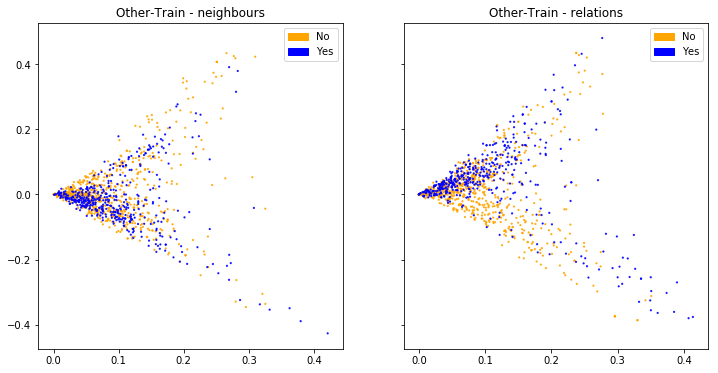

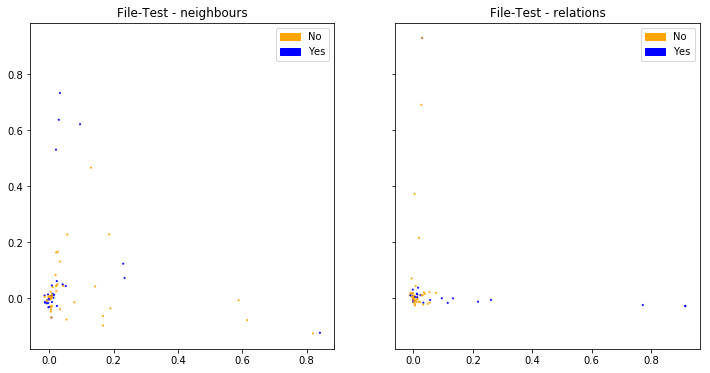

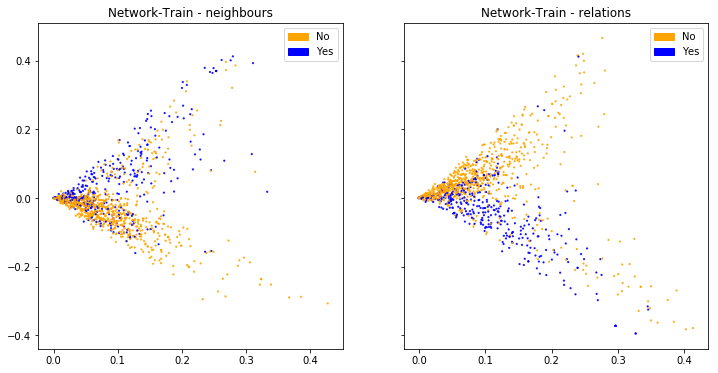

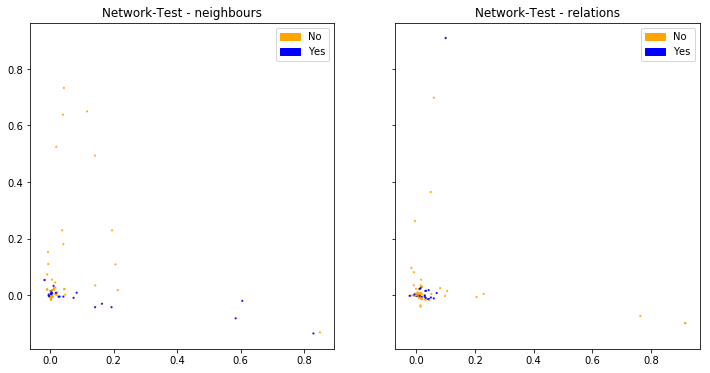

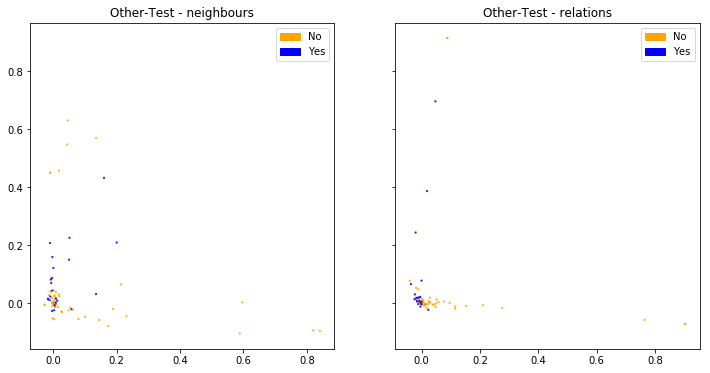

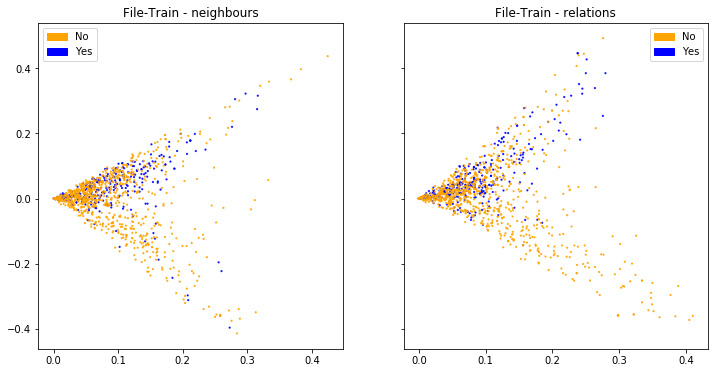

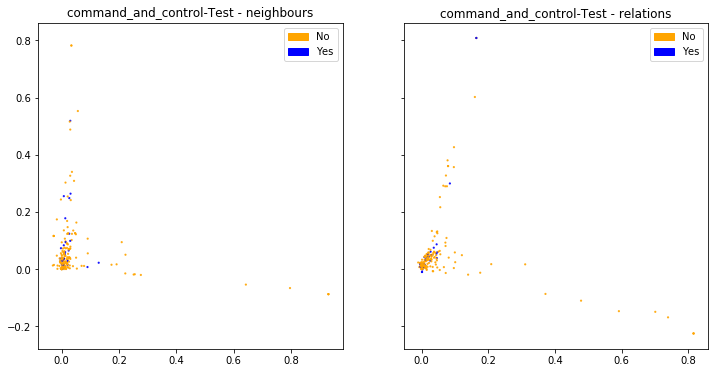

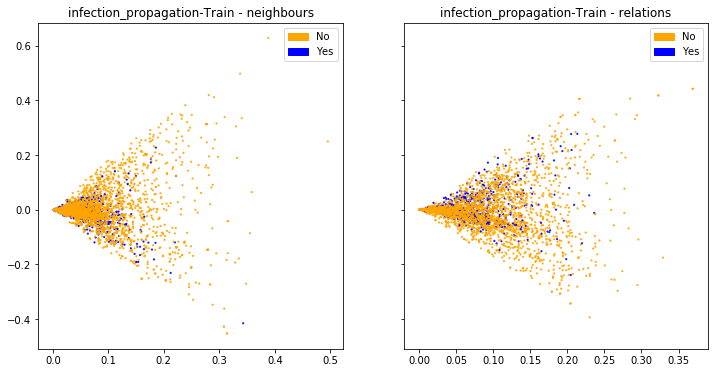

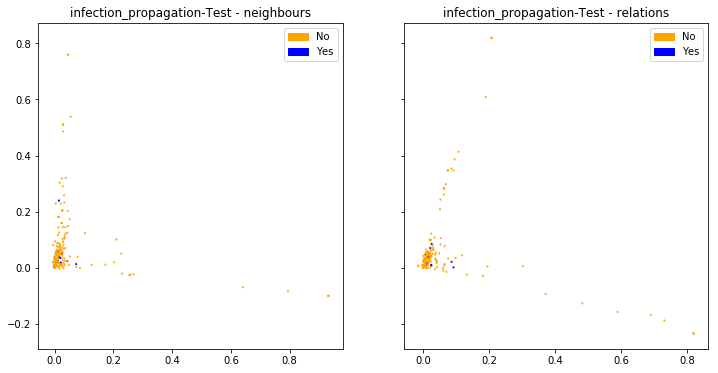

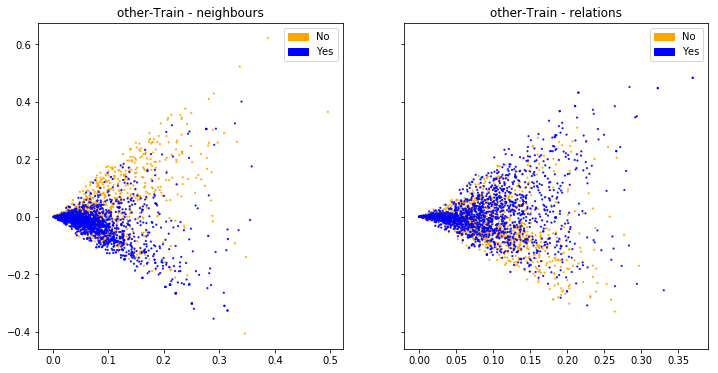

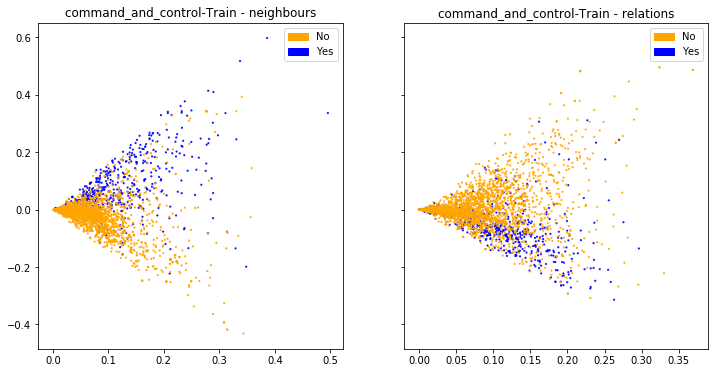

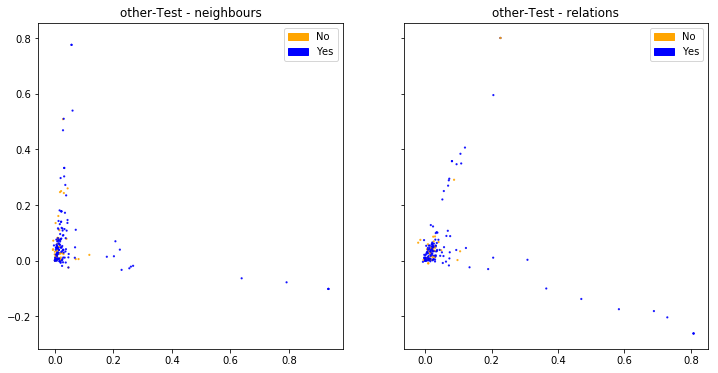

In [32]:
for cat in dataframes.keys():

    df = dataframes[cat]
    labels = df['label_num'].tolist()
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
    
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens'])
    plot_LSA(X_counts, labels, ax1)
    ax1.set_title("{} - neighbours".format(cat))
    
    X_counts = vectorizer.fit_transform(df['text-rel-tokens'])
    plot_LSA(X_counts, labels, ax2)
    ax2.set_title("{} - relations".format(cat))

In [33]:
'''
Now for the n-grams! 
Are there bigrams more interesting for the classifier than unigrams?
'''

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    ngram_range=(1, 3)
)

'''
Let's search for bigrams, which position are they,
if we also take unigrams into consideration?

(COUNT VECTORIZER)
'''

for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    feature_count = 10 if 'Test' in cat else 100
    # because we expect nothing special from test dataset
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))
            
    
    print("\nModel 'sąsiedzi':")
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))


>>> Other-Train

Model z relacjami:
bag-of-words: 10238
- NoOther
45. : command control, 19.0
57. : execut file, 16.0
60. : c&c server, 16.0
73. : download file, 13.0
76. : ip address, 13.0
82. : control server, 12.0
98. : command control server, 10.0
- Other
26. : post request, 22.0
43. : registri key, 16.0
49. : get request, 14.0
53. : http post, 13.0
62. : system-path system-path, 11.0
70. : http post request, 10.0
74. : pipe server, 9.0
78. : name pipe, 9.0
80. : dll modul, 8.0
97. : network share, 7.0
98. : http get request, 7.0
99. : http get, 7.0

Model 'sąsiedzi':
bag-of-words: 9447
- NoOther
26. : download execut, 22.0
58. : execut file, 13.0
64. : upload download, 12.0
87. : disk execut, 9.0
97. : download file, 9.0
- Other
49. : post request, 11.0
55. : registri key, 10.0
61. : get request, 9.0
68. : driver hook, 8.0
71. : http post, 8.0
81. : dll modul, 7.0
96. : usermod dll, 6.0
97. : load dll, 6.0

>>> File-Test

Model z relacjami:
bag-of-words: 844
- File
4. : event log

KeyboardInterrupt: 

In [15]:
'''
Check scores considering n-grams for TDIDF Vectorizer!
'''

vectorizer = TfidfVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    ngram_range=(1,3)
)

for cat in dataframes.keys():
    print("\n>>> {}".format(cat))
    df = dataframes[cat]
    
    feature_count = 10 if 'Test' in cat else 100
    # because we expect nothing special from test dataset
    
    print("\nModel z relacjami:")
    X_counts = vectorizer.fit_transform(df['text-rel-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))
            
    
    print("\nModel 'sąsiedzi':")
    X_counts = vectorizer.fit_transform(df['text-neigh-tokens']) # stwórz macierz liczbową z danych. W wierszach mamy kolejne dokumenty, w kolumnach kolejne pola wektora cech odpowiadające unikalnym słowom (bag of words)
    print("bag-of-words: {x}".format(x=X_counts.shape[1]))
    result = get_top_occuring_words(X_counts, feature_count, vectorizer, df)
    for entry in result:
        category = entry[0]
        print("-", category)
        words = entry[1]
        for idx, word in enumerate(words):
            len_check = len(word[0].split())
            if len_check > 1:
                print("{}. : {}, {}".format(idx, word[0], word[1]))


>>> ActionName-Train

Model z relacjami:
bag-of-words: 30775
- ActionName
47. : download file, 5.839672193343967
56. : execut file, 5.001764667127984
64. : post request, 4.601443536432968
69. : upload file, 4.3525977951713415
83. : command control, 3.727395518858263
92. : c&c server, 3.4038398288696743
- NoActionName
35. : c&c server, 9.282584717553169
41. : command control, 8.92652424556101
82. : attack use, 5.516364230587741
85. : ip address, 5.450388832132534

Model 'sąsiedzi':
bag-of-words: 25913
- ActionName
40. : download execut, 5.3181342086504815
88. : execut file, 3.164302576102987
92. : upload download, 3.049998721769038
- NoActionName
54. : c&c server, 6.728795838029409

>>> ActionName-Test

Model z relacjami:
bag-of-words: 2604
- ActionName
- NoActionName
4. : c&c server, 2.673775449766095

Model 'sąsiedzi':
bag-of-words: 2265
- ActionName
9. : download execut, 1.1457942846834346
- NoActionName
6. : c&c server, 1.9204115043608707

>>> Capability-Train

Model z relacjami:
b

In [ ]:
'''
Saving processed data to file
'''

main_cats = ['ActionName', 'Capability']
subfolder = 'Processed'
for ccat in dataframes.keys():
    cat = 'ActionName' if ccat[0].isupper() else 'Capability'
    sub_path = os.getcwd() + "/" + cat + "/" + subfolder
    new_filename = '{}-P.csv'.format(ccat)
    dataframes[ccat].to_csv(sub_path + "/" + new_filename)
